In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:

#general libraries 
import numpy as np 
import pandas as pd 
import os
import random
from sklearn.utils import shuffle
import shutil

#visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches

# work with images
from skimage.transform import rotate
from skimage import io
import cv2 as cv

# model development
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.layers import  RandomZoom, RandomRotation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

In [4]:
tf.__version__

'2.6.4'

In [5]:
#get files
train_path = '/kaggle/input/concetto22/concetto_CDT/concetto_CDT/'
sample_submission = pd.read_csv('/kaggle/input/concetto22/sample_submission.csv')
train_data = pd.read_csv('/kaggle/input/concetto22/train.csv')

In [6]:
train_data.head()

,id,tar
0,20002859.0,5.0
1,10011157.0,5.0
2,10011996.0,5.0
3,10000364.0,5.0
4,20004294.0,3.0


In [7]:
train_data.describe()

,id,tar
count,2.540000e+03,2540.000000
mean,1.488287e+07,4.040157
std,4.998207e+06,0.992668
min,1.000001e+07,0.000000
25%,1.000600e+07,4.000000
50%,1.001215e+07,4.000000
75%,2.000362e+07,5.000000
max,2.000711e+07,5.000000


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2540 entries, 0 to 2539
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      2540 non-null   float64
 1   tar     2540 non-null   float64
dtypes: float64(2)
memory usage: 39.8 KB


     Label Counts
5.0           977
4.0           954
3.0           398
2.0           162
1.0            43
0.0             6


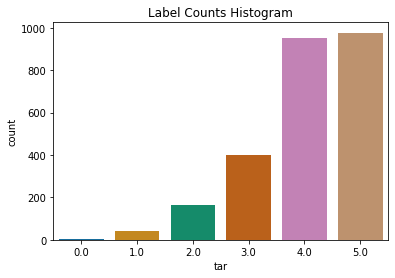

In [9]:
print(pd.DataFrame(data={'Label Counts': train_data['tar'].value_counts()}))
sns.countplot(x=train_data['tar'], palette='colorblind').set(title='Label Counts Histogram');

In [10]:
#create pie chart
fig = px.pie(train_data, 
             values = train_data['tar'].value_counts().values, 
             names = train_data['tar'].unique())
fig.update_layout(
    title={
        'text': "Label Percentage Pie Chart",
        'y':.99,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [11]:
# fig, ax = plt.subplots(5, 5, figsize=(15, 15))
# for i, axis in enumerate(ax.flat):
#     st = str(train_data['id'][i])
#     st = st.replace('.0','.tif')
#     file = str(train_path + st)
#     image = io.imread(file)
#     axis.imshow(image)
#     box = patches.Rectangle((32,32),32,32, linewidth=2, edgecolor='r',facecolor='none', linestyle='-')
#     axis.add_patch(box)
#     axis.set(xticks=[], yticks=[], xlabel = train_data.label[i]);
#     #cv2.waitKey(0)

In [12]:
BATCH_SIZE = 256
RANDOM_STATE = 49

In [13]:
# prepare data for training
def append_tif(string):
    return str(string)[:-1]+"tif"

train_data["id"] = train_data["id"].apply(append_tif)
train_data['tar'] = train_data['tar'].astype(str)

# randomly shuffle training data
train_data = shuffle(train_data, random_state=RANDOM_STATE)

In [14]:
print(train_data)

                id  tar
1961  10006410.tif  4.0
1971  10000754.tif  4.0
1395  10003913.tif  2.0
1301  10012316.tif  4.0
2367  20004831.tif  5.0
...            ...  ...
2501  10006266.tif  4.0
908   20000651.tif  2.0
424   10010669.tif  4.0
1709  10008107.tif  5.0
426   10005328.tif  3.0

[2540 rows x 2 columns]


In [15]:
# modify training data by normalizing it 
# and split data into training and validation sets
datagen = ImageDataGenerator(rescale=1./255.,
                            validation_split=0.15)

In [16]:
# generate training data
train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    color_mode="grayscale",
    x_col="id",
    y_col="tar",
    subset="training",
    batch_size=BATCH_SIZE,
    seed=RANDOM_STATE,
    class_mode="categorical",
    target_size=(256,256))

Found 2159 validated image filenames belonging to 6 classes.


In [17]:
valid_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    color_mode="grayscale",
    x_col="id",
    y_col="tar",
    subset="validation",
    batch_size=BATCH_SIZE,
    seed=RANDOM_STATE,
    class_mode="categorical",
    target_size=(256,256))   

Found 381 validated image filenames belonging to 6 classes.


In [18]:
# for i in valid_generator:
# #     input()
#     print(i[0][0].shape)

In [19]:
ROC_1 = tf.keras.metrics.AUC()
from tensorflow.keras import layers
from tensorflow.keras import regularizers
# use GPU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.utils import to_categorical

# model = Sequential()
# model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (256,256,1)))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

# model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

# model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

# model.add(Flatten())

# model.add(Dense(units = 128 ,kernel_regularizer=regularizers.l2(0.001), activation = 'relu'))
# model.add(Dropout(0.5))

# model.add(Dense(units = 32 ,kernel_regularizer=regularizers.l2(0.001), activation = 'relu'))

# model.add(Dense(units = 6 ,kernel_regularizer=regularizers.l2(0.001), activation = 'softmax'))
# model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
# model.summary()

2022-10-22 21:56:23.154034: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-22 21:56:23.158093: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-22 21:56:23.158826: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-22 21:56:23.160738: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [20]:
# EPOCHS = 10

# # train the model
# history_model_one = model.fit(
#                         train_generator,
#                         epochs = EPOCHS,
#                         validation_data = valid_generator)

In [22]:
# # plot model accuracy per epoch 
# plt.plot(history_model_one.history['accuracy'])
# plt.plot(history_model_one.history['val_accuracy'])
# plt.title('Model One Accuracy per Epoch')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'validate'], loc='upper left')
# plt.show();

# # plot model loss per epoch
# plt.plot(history_model_one.history['loss'])
# plt.plot(history_model_one.history['val_loss'])
# plt.title('Model One Loss per Epoch')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'validate'], loc='upper left')
# plt.show();

# # plot model ROC per epoch
# plt.plot(history_model_one.history['auc'])
# plt.plot(history_model_one.history['val_auc'])
# plt.title('Model One AUC ROC per Epoch')
# plt.ylabel('ROC')
# plt.xlabel('epoch')
# plt.legend(['train', 'validate'], loc='upper left')
# plt.show();

In [23]:
model_one = Sequential()
model_one.add(Conv2D(16 , (5,3) , strides = 1 , padding = 'same' , activation = 'elu' , input_shape = (256,256,1)))
model_one.add(BatchNormalization())
model_one.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model_one.add(Conv2D(32 , (5,3) , strides = 1 , padding = 'same' , activation = 'selu'))
model_one.add(Dropout(0.2))
model_one.add(BatchNormalization())
model_one.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model_one.add(Conv2D(64, (5,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_one.add(BatchNormalization())
model_one.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_one.add(Dropout(0.2))

model_one.add(Flatten())
model_one.add(Dense(units = 256 ,kernel_regularizer=regularizers.l2(0.001), activation = 'relu'))
model_one.add(Dropout(0.4))
model_one.add(Dense(units = 128 ,kernel_regularizer=regularizers.l2(0.001), activation = 'relu'))

model_one.add(Dense(units = 6 ,kernel_regularizer=regularizers.l2(0.001), activation = 'softmax'))
model_one.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model_one.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      256       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      7712      
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0

In [ ]:
EPOCHS = 100

# train the model
history_model_one = model_one.fit(
                        train_generator,
                        epochs = EPOCHS,
                        validation_data = valid_generator)

2022-10-22 21:56:51.979629: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-10-22 21:56:57.126703: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


9/9 [==============================] - 40s 4s/step - loss: 19.6331 - accuracy: 0.3140 - val_loss: 2.3492 - val_accuracy: 0.3622
Epoch 2/100
9/9 [==============================] - 24s 3s/step - loss: 4.8702 - accuracy: 0.3465 - val_loss: 2.9797 - val_accuracy: 0.0814
Epoch 3/100
9/9 [==============================] - 24s 3s/step - loss: 3.4631 - accuracy: 0.3747 - val_loss: 2.7178 - val_accuracy: 0.3648
Epoch 4/100
9/9 [==============================] - 28s 3s/step - loss: 2.9948 - accuracy: 0.4238 - val_loss: 2.7831 - val_accuracy: 0.3648
Epoch 5/100
9/9 [==============================] - 24s 3s/step - loss: 2.8833 - accuracy: 0.4507 - val_loss: 2.7979 - val_accuracy: 0.3596
Epoch 6/100
9/9 [==============================] - 24s 3s/step - loss: 2.6471 - accuracy: 0.4595 - val_loss: 2.7384 - val_accuracy: 0.3701
Epoch 7/100
9/9 [==============================] - 24s 3s/step - loss: 2.4840 - accuracy: 0.4836 - val_loss: 2.7539 - val_accuracy: 0.3675
Epoch 8/100
9/9 [=====================

In [ ]:
sample_submission.head()

In [ ]:
test_id = []
import csv
from PIL import Image
with open ("/kaggle/input/concetto22/test.csv", "r") as file:
    csvFile = csv.reader(file)
    for lines in csvFile:
        test_id.append(lines)
file.close()
img_dir = "/kaggle/input/concetto22/concetto_CDT/concetto_CDT/"
ans = [["id", "tar"]]

for i in test_id[1:]:
    im = np.array(Image.open(img_dir + i[0][:-1] + "tif").resize((256, 256)), dtype = "uint8")
    if im.shape == (256, 256, 4):
        im = im.mean(axis = 2)
    ans.append([i[0], np.argmax(model.predict(im.reshape(1, 256, 256, 1)))])
    
with open("./submission.csv", 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    for a in ans:
        writer.writerow(a)
f.close()